# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Начнем работу с импорта необходимых для работы библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

Откроем датасет, выведем первые несколько строк датасета, а также выведем информацию о нем

In [2]:
data = pd.read_csv('/datasets/autos.csv')
display(data.head(10))
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Как мы видим во многих столбцах имеются пропуски (зачастую они составляют небольшое количество относительно общего числа данных в каждом из столбцов).

Посмотрим подробнее на значения в столбце с количество фотографий автомобиля ('NumberOfPictures') 

In [3]:
print(data['NumberOfPictures'].value_counts())

0    354369
Name: NumberOfPictures, dtype: int64


Как мы видим все значения в данном столбце нулевые и мы не можем это исправить

Посмотрим на столбец 'DateCrawled' (дата скачивания анкеты из базы) чтобы определиться каким временным интервалом мы ограничены

In [4]:
print(data.sort_values('DateCrawled', ascending = False)['DateCrawled'])

90713     2016-04-07 14:36:58
339649    2016-04-07 14:36:56
301030    2016-04-07 14:36:55
53739     2016-04-07 14:36:54
204218    2016-04-07 14:36:53
                 ...         
99885     2016-03-05 14:06:24
324763    2016-03-05 14:06:24
176823    2016-03-05 14:06:24
220583    2016-03-05 14:06:23
329497    2016-03-05 14:06:22
Name: DateCrawled, Length: 354369, dtype: object


Как мы видим наши данные сформированы на 2016 год

Посмотрим на наличие дубликатов в нашем датасете

In [5]:
print(data.duplicated().sum())

4


Как мы видим их совсем немного - удалим их

In [6]:
data = data.drop_duplicates().reset_index(drop=True)

Нам необходимо будет предсказать цену авто, поэтому некоторые столбцы датасета будут для нас неинформативны - в частности: дата скачивания анкеты из базы ('DateCrawled'), дата создания анкеты ('DateCreated'), количество фотографий автомобиля ('NumberOfPictures') - тем более в этом столбце только нулевые значения, почтовый индекс владельца анкеты ('PostalCode'), дата последней активности пользователя ('LastSeen'). Удалим эти столбцы и посмотрим на получившийся датасет.

In [7]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
display(data.sample(10))
data.info()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
16077,9500,wagon,2008,manual,140,a3,150000,4,gasoline,audi,no
195117,2490,sedan,2004,manual,109,3_reihe,150000,9,gasoline,mazda,no
206268,1840,sedan,1997,manual,193,a4,150000,0,petrol,audi,NaN
286395,9500,wagon,2011,auto,310,a4,80000,4,gasoline,audi,no
307533,19500,wagon,2011,auto,143,a4,90000,8,gasoline,audi,no
149374,15700,suv,2011,manual,122,NaN,60000,12,petrol,volkswagen,no
264061,800,wagon,1993,manual,140,850,150000,7,petrol,volvo,no
34175,149,NaN,2005,NaN,0,m_klasse,5000,0,NaN,mercedes_benz,NaN
102462,10900,bus,2010,manual,145,5_reihe,80000,4,petrol,mazda,no
339668,3800,small,2001,manual,75,a2,150000,10,gasoline,audi,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        316875 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            334532 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              334660 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           321470 non-null  object
 9   Brand              354365 non-null  object
 10  Repaired           283211 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


Посмотрим на значения в столбце 'Price' и построим по значениям этого столбца график

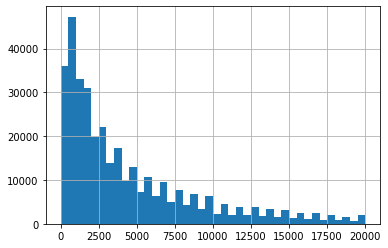

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64


In [8]:
data['Price'].hist(bins=40)
plt.show()
print(data['Price'].value_counts())

Как мы видим у нас имеется 10 тыс. нулевых значений цены - это явные аномалии. Удалим их

In [9]:
data = data.loc[data['Price']!=0]

Далее посмотрим какие еще значения у нас имеются в датасете и отсортируем значения

In [10]:
print(data.sort_values('Price')['Price'])

322319        1
102202        1
183699        1
46837         1
294681        1
          ...  
17724     20000
94187     20000
76411     20000
307572    20000
312213    20000
Name: Price, Length: 343593, dtype: int64


Как мы видим у нас имеются значения цены равные 1 евро - что не очень похоже на правду для цены авто, однако мы вряд ли сможем точно установить минимальный порог цены на авто (вдруг кто-то желает избавиться от своего авто за "символическую цену") - обозначим минимальный порог стоимости авто в 100 евро

In [11]:
data = data.loc[data['Price'] > 100]

Посмотрим на значения в столбце 'VehicleType' и построим по значениям этого столбца график, а также посмотрим на пропуски в этом столбце

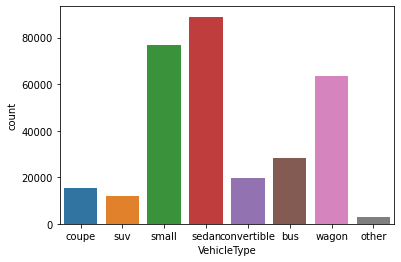

sedan          88965
small          77028
wagon          63383
bus            28256
convertible    19807
coupe          15532
suv            11758
other           3040
Name: VehicleType, dtype: int64

32251


In [12]:
sns.countplot(data=data, x='VehicleType')
plt.show()
print(data['VehicleType'].value_counts())
print()
print(data['VehicleType'].isna().sum())

Как мы видим у нас имеется довольно много пропусков в этом столбце и они составляют около 10% от общего объема данных, поэтому удалить их просто так не получится. Остается заменить все пропуски на значение 'unknown'

In [13]:
data['VehicleType'] = data['VehicleType'].fillna('unknown')

Посмотрим на значения в столбце 'RegistrationYear', а также оценим количество пропусков в нем

In [14]:
print(data['RegistrationYear'].value_counts())
print()
print(data['RegistrationYear'].isna().sum())

2000    22496
1999    21779
2005    21341
2006    19639
2001    19549
        ...  
1946        1
1949        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 136, dtype: int64

0


Как мы видим пропуски отсутствуют, но имеются явно аномальные значения в годах регистрации. Как-то логично исправить такие значения не получится, поэтому удалим значения годов до 1885 (год создания первого автомобиля) и после 2016 года (т.к. данные выгружены в этом году)

In [15]:
data = data.loc[data['RegistrationYear'] > 1885]
data = data.loc[data['RegistrationYear'] <= 2016]

Посмотрим на значения в столбце 'Gearbox' и построим по значениям этого столбца график, а также посмотрим на пропуски в этом столбце

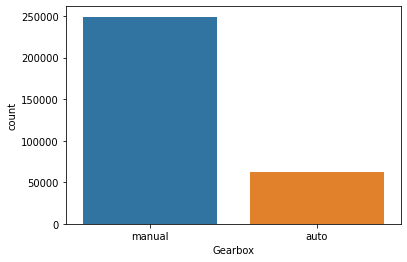

manual    249168
auto       62763
Name: Gearbox, dtype: int64

14376


In [16]:
sns.countplot(data=data, x='Gearbox')
plt.show()
print(data['Gearbox'].value_counts())
print()
print(data['Gearbox'].isna().sum())

Как мы видим у нас ощутимо больше машин с ручной коробкой передач, а также имеются пропуски. Заполнить их вы вряд ли сможем т.к. для многих машин одной модели обычно доступны комплектации с разными коробками передач - поэтому заполним пропуски значением 'unknown'

In [17]:
data['Gearbox'] = data['Gearbox'].fillna('unknown')

Посмотрим на значения в столбце 'Power' и построим по значениям этого столбца график

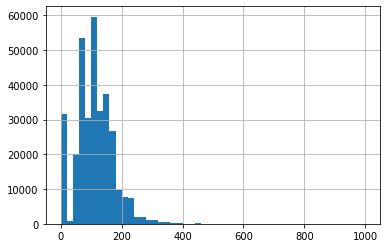

0        31209
75       21919
60       14559
150      13688
101      12374
         ...  
1625         1
685          1
1799         1
15017        1
903          1
Name: Power, Length: 681, dtype: int64


In [18]:
data['Power'].hist(bins=50, range=(0, 1000))
plt.show()
print(data['Power'].value_counts())

Как мы видим у нас имеются явные аномалии в данных - автомобили с 0 мощностью, а также со слишком большой мощностью (более 1000 л.с.). Как-то исправить слишком большую мощность сложно, т.к. это не похоже на опечатку и лишнее количество нулей, нулевую мощность мы также вряд ли сможем исправить - т.к. ориентироваться на авто с имеющейся информацией о мощности не совсем корректно из-за различных двигателей и комплектаций для одной модели машин. Удалим строки с мощностью менее 10 л.с. и более 1000 л.с. - т.к. такие большие значения мощности почти не встречаются кроме нескольких не серийных суперкаров

In [19]:
data = data.loc[data['Power'] > 10]
data = data.loc[data['Power'] < 1000]

Посмотрим на значения в столбце 'Model', а также оценим количество пропусков в нем

In [20]:
print(data['Model'].value_counts())
print()
print(data['Model'].isna().sum())

golf                  24566
other                 20326
3er                   17318
polo                  10561
corsa                  9963
                      ...  
samara                    5
kalina                    5
serie_3                   3
rangerover                2
range_rover_evoque        2
Name: Model, Length: 249, dtype: int64

10876


Как мы видим у нас имеется некоторое количество пропусков, которые мы вряд ли сможем заполнить как-то логично, поэтому заполним пропуски значением 'unknown'

In [21]:
data['Model'] = data['Model'].fillna('unknown')

Посмотрим на значения в столбце 'Kilometer' и построим по значениям этого столбца график, а также оценим количество пропусков в нем

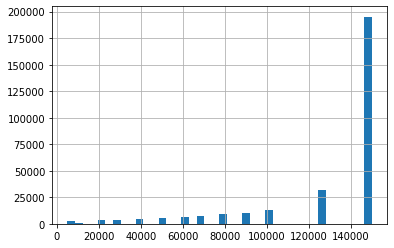

150000    195219
125000     31714
100000     12799
90000      10285
80000       9015
70000       7802
60000       6834
50000       5650
40000       4499
30000       3881
20000       3242
5000        2767
10000        917
Name: Kilometer, dtype: int64

0


In [22]:
data['Kilometer'].hist(bins=40)
plt.show()
print(data['Kilometer'].value_counts())
print()
print(data['Model'].isna().sum())

Как мы видим пропуски отсутствуют, больше всего машин с пробегом более 150 тыс.км - возможно это максимально допустимый пробег для продажи авто на этом сайте

Посмотрим на значения в столбце 'RegistrationMonth' и построим по значениям этого столбца график, а также посмотрим на пропуски в этом столбце

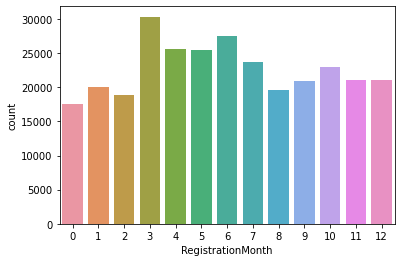

3     30327
6     27463
4     25655
5     25521
7     23755
10    22892
12    21120
11    20986
9     20892
1     20082
8     19661
2     18792
0     17478
Name: RegistrationMonth, dtype: int64

0


In [23]:
sns.countplot(data=data, x='RegistrationMonth')
plt.show()
print(data['RegistrationMonth'].value_counts())
print()
print(data['RegistrationMonth'].isna().sum())

Как мы видим у нас присутствует 'лишний' месяц - скорее всего владелец забыл когда регистрировал автомобиль, были утеряны документы на регистрацию или по другим причинам не известен месяц регистрации. Однако данные по месяцам распределены относительно равномерно, поэтому не будем ничего предпринимать.

Посмотрим на значения в столбце 'FuelType' и построим по значениям этого столбца график, а также посмотрим на пропуски в этом столбце

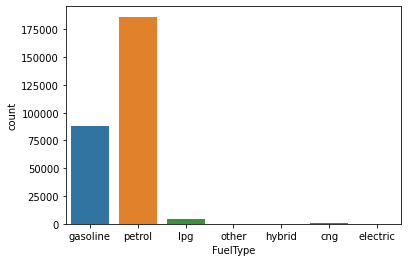

petrol      186331
gasoline     87594
lpg           4676
cng            480
hybrid         201
other           85
electric        63
Name: FuelType, dtype: int64

15194


In [24]:
sns.countplot(data=data, x='FuelType')
plt.show()
print(data['FuelType'].value_counts())
print()
print(data['FuelType'].isna().sum())

Как мы видим у нас ощутимо больше машин с бензиновым двигателем, а также имеются пропуски. Заполнить их вы вряд ли сможем т.к. для многих машин одной модели часто доступны комплектации с разными двигателями - поэтому заполним пропуски значением 'unknown'

In [25]:
data['FuelType'] = data['FuelType'].fillna('unknown')

Посмотрим на значения в столбце 'Brand', а также оценим количество пропусков в нем

In [26]:
print(data['Brand'].value_counts())
print()
print(data['Brand'].isna().sum())

volkswagen        63717
opel              32207
bmw               32149
mercedes_benz     27285
audi              25554
ford              20510
renault           13816
peugeot            9369
fiat               7609
seat               5815
skoda              4941
mazda              4701
smart              4480
citroen            4227
nissan             4021
toyota             4009
hyundai            3099
mini               2961
volvo              2812
mitsubishi         2477
honda              2357
kia                2081
alfa_romeo         1965
suzuki             1949
sonstige_autos     1693
chevrolet          1462
chrysler           1155
dacia               800
subaru              637
porsche             624
daihatsu            605
jeep                579
saab                472
land_rover          465
jaguar              436
daewoo              402
lancia              378
rover               361
trabant             287
lada                157
Name: Brand, dtype: int64

0


Как мы видим пропуски отсутствуют, дубликатов в названиях нет, двигаемся дальше

Посмотрим на значения в столбце 'Repaired' и построим по значениям этого столбца график, а также посмотрим на пропуски в этом столбце

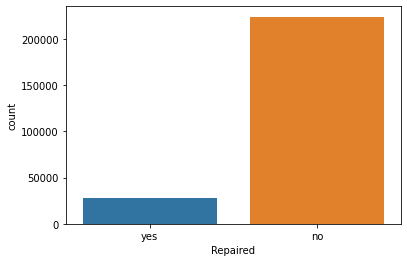

no     224087
yes     28262
Name: Repaired, dtype: int64

42275


In [27]:
sns.countplot(data=data, x='Repaired')
plt.show()
print(data['Repaired'].value_counts())
print()
print(data['Repaired'].isna().sum())

Как мы видим у нас ощутимо больше машин не бывавших в ремонте, а также много пропусков. Как-то логично заполнить пропуски мы не можем, поэтому заполним их значением 'unknown'

In [28]:
data['Repaired'] = data['Repaired'].fillna('unknown')

Выведем информацию о нашем датасете после предобработки данных

In [29]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294624 entries, 1 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              294624 non-null  int64 
 1   VehicleType        294624 non-null  object
 2   RegistrationYear   294624 non-null  int64 
 3   Gearbox            294624 non-null  object
 4   Power              294624 non-null  int64 
 5   Model              294624 non-null  object
 6   Kilometer          294624 non-null  int64 
 7   RegistrationMonth  294624 non-null  int64 
 8   FuelType           294624 non-null  object
 9   Brand              294624 non-null  object
 10  Repaired           294624 non-null  object
dtypes: int64(5), object(6)
memory usage: 35.0+ MB
None


Как мы видим пропуски в данных отсутствуют и остались только необходимые для нас столбцы

<b>Вывод: </b> Мы оценили исходный датасет, узнали его размер, избавились от дубликатов и лишних столбцов, заполнили пропуски и построили по каждому столбцу графики

## Обучение моделей

Перед обучением модели нам необходимо разделить датасет на выборки

Разобьем данные на выборки: выделим 20% данных для тестовой выборки, остальные 80% — для обучающей и валидационной

In [30]:
data_train_valid, data_test = train_test_split(data, test_size=0.2, random_state=12345)

Далее из обучающей и валидационной выборок выделим каждую из них по отдельности. На валидационную выделим 25%, а на обучающую 75%

In [31]:
data_train, data_valid = train_test_split(data_train_valid, test_size=0.25, random_state=12345)

Целевым признаком в нашем датасете является столбец "Price" - именно в нем содержится информацию о цене автомобиля (в евро) и его нам необходимо будет предсказывать. Остальные столбцы датасета будут признаками. Создадим переменные для признаков и целевого признака для каждой выборки

In [32]:
features_train = data_train.drop(['Price'], axis=1)
target_train = data_train['Price']
features_valid = data_valid.drop(['Price'], axis=1)
target_valid = data_valid['Price']
features_test = data_test.drop(['Price'], axis=1)
target_test = data_test['Price']

Для преобразования категориальных признаков в численные для модели 'Линейной регрессии' воспользуемся техникой OHE

In [33]:
category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(features_train[category])

features_train_ohe = ohe.transform(features_train[category]).toarray()
features_valid_ohe = ohe.transform(features_valid[category]).toarray()
features_test_ohe = ohe.transform(features_test[category]).toarray()

df_features_train_ohe = pd.DataFrame(features_train_ohe, index=features_train.index)
df_features_valid_ohe = pd.DataFrame(features_valid_ohe, index=features_valid.index)
df_features_test_ohe = pd.DataFrame(features_test_ohe, index=features_test.index)

Для преобразования категориальных признаков в численные воспользуемся техникой порядкового кодирования (Ordinal Encoding)

In [34]:
category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

encoder = OrdinalEncoder()
encoder.fit(features_train[category])

features_train[category] = encoder.transform(features_train[category])
features_valid[category] = encoder.transform(features_valid[category])
features_test[category] = encoder.transform(features_test[category])

Стандартизируем численные признаки. Перед этим в переменной numeric создадим список всех численных признаков

In [35]:
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
scaler = StandardScaler() 
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [36]:
scaler = StandardScaler() 
scaler.fit(df_features_train_ohe)

df_features_train_ohe = scaler.transform(df_features_train_ohe)
df_features_valid_ohe = scaler.transform(df_features_valid_ohe)
df_features_test_ohe = scaler.transform(df_features_test_ohe)

Применим модель "Линейная регрессия" и вычислим RMSE на данных закодированных OHE

In [37]:
%%time
 
model = LinearRegression()
model.fit(df_features_train_ohe, target_train)
print('Время обучения модели:')

Время обучения модели:
CPU times: user 14 s, sys: 7.43 s, total: 21.4 s
Wall time: 21.4 s


In [38]:
%%time

predictions = model.predict(df_features_valid_ohe)
mse = mean_squared_error(target_valid, predictions)
rmse = mse ** 0.5
print('RMSE Линейной регрессии:', rmse)
print('Время предсказания модели:') 

RMSE Линейной регрессии: 3581.793830116426
Время предсказания модели:
CPU times: user 65.5 ms, sys: 66.9 ms, total: 132 ms
Wall time: 102 ms


Как мы видим модель "Линейная регрессия" имеет быстрое время обучения (около 37 сек) и предсказания (менее секунды), но не обеспечивает требуемое нам значение RMSE (<2500) - попробуем другие модели

Применим модель "Дерево решений": подберем наилучшие параметры и вычислим RMSE

In [39]:
%%time

best_model = None
best_rmse = 5000
for i in range(2, 15):
    for j in range(2,15):
            model = DecisionTreeClassifier(random_state=12345, max_depth=i, min_samples_leaf=j)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            mse = mean_squared_error(target_valid, predictions)
            rmse = mse ** 0.5
            if rmse < best_rmse:
                best_model = model
                best_rmse = rmse
print("Параметры наилучшей модели:", best_model)
print("RMSE лучшей модели:", best_rmse)

Параметры наилучшей модели: DecisionTreeClassifier(max_depth=13, min_samples_leaf=12, random_state=12345)
RMSE лучшей модели: 2248.8244282825995
CPU times: user 3min 19s, sys: 1min 5s, total: 4min 24s
Wall time: 4min 25s


Узнав наилучшие параметры для модели "Дерево решений" посмотрим сколько времени у нас займет обучение и предсказание модели

In [40]:
%%time

model = DecisionTreeClassifier(random_state=12345, max_depth=12, min_samples_leaf=10)
model.fit(features_train, target_train)
print('Время обучения модели:')

Время обучения модели:
CPU times: user 1.51 s, sys: 108 ms, total: 1.62 s
Wall time: 1.63 s


In [41]:
%%time

predictions = model.predict(features_valid)
mse = mean_squared_error(target_valid, predictions)
rmse = mse ** 0.5
print('RMSE модели "Дерево решений":', rmse)
print('Время предсказания модели:') 

RMSE модели "Дерево решений": 2289.7308529548336
Время предсказания модели:
CPU times: user 377 ms, sys: 372 ms, total: 749 ms
Wall time: 759 ms


Как мы видим модель "Дерево решений" имеет очень быстрое время обучения и предсказания (2 и 1 секунда), а также обеспечивает требуемое нам значение RMSE ( 2289 ), но подбор наилучших параметров занимает ощутимое время (около 5 мин)

Применим модель "Случайный лес". Учитывая, что подбор параметров для модели "Случайный лес" обычно занимет еще больше времени чем для модели "Дерево решений" попробуем вручную поменять некоторые параметры и зафиксируем результат

In [42]:
%%time

model = RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=30)
model.fit(features_train, target_train)
print('Время обучения модели:')

Время обучения модели:
CPU times: user 53 s, sys: 924 ms, total: 53.9 s
Wall time: 54.2 s


In [43]:
%%time

predictions = model.predict(features_valid)
mse = mean_squared_error(target_valid, predictions)
rmse = mse ** 0.5
print('RMSE модели "Случайный лес":', rmse)
print('Время предсказания модели:') 

RMSE модели "Случайный лес": 1583.896481841222
Время предсказания модели:
CPU times: user 2.48 s, sys: 25.8 ms, total: 2.51 s
Wall time: 2.52 s


Как мы видим модель "Случайный лес" довольно быстро обучается (около 1 мин), быстро предсказывает (4 сек) и показывает хорошее значение RMSE ( 1583 )

Попробуем LGBM модель и вычислим RMSE. Параметры будем также пробовать вручную

In [44]:
%%time

model = lgb.LGBMRegressor(max_depth=150, n_estimators=100)
model.fit(features_train, target_train)
print('Время обучения модели:')

Время обучения модели:
CPU times: user 4min, sys: 5.59 s, total: 4min 5s
Wall time: 4min 7s


In [45]:
%%time

predictions = model.predict(features_valid)
mse = mean_squared_error(target_valid, predictions)
rmse = mse ** 0.5
print('RMSE модели LGBM:', rmse)
print('Время предсказания модели:') 

RMSE модели LGBM: 1660.2273899370607
Время предсказания модели:
CPU times: user 535 ms, sys: 0 ns, total: 535 ms
Wall time: 507 ms


Как мы видим модель "LGBM" имеет быстрое время обучения (6 сек - 6 мин, модель с одними и теме же параметрами может показывать разное время, отличающееся порой в десятки раз), быстрое время предсказания (615 мс) и обеспечивает требуемое нам значение RMSE ( 1660 )

Применим модель "CatBoost" пробуя разные параметры

In [46]:
%%time

model =  CatBoostRegressor(iterations=300)
model.fit(features_train, target_train, verbose=20)
print('Время обучения модели:')

Learning rate set to 0.246815
0:	learn: 3902.4739899	total: 77.8ms	remaining: 23.3s
20:	learn: 1911.1966798	total: 638ms	remaining: 8.48s
40:	learn: 1798.2684168	total: 1.15s	remaining: 7.26s
60:	learn: 1740.9178053	total: 1.63s	remaining: 6.38s
80:	learn: 1702.0904540	total: 2.2s	remaining: 5.95s
100:	learn: 1674.6619801	total: 2.74s	remaining: 5.39s
120:	learn: 1648.4941932	total: 3.21s	remaining: 4.75s
140:	learn: 1628.3319804	total: 3.75s	remaining: 4.22s
160:	learn: 1613.2580598	total: 4.25s	remaining: 3.67s
180:	learn: 1599.6029548	total: 4.72s	remaining: 3.1s
200:	learn: 1587.0143921	total: 5.21s	remaining: 2.56s
220:	learn: 1575.2597753	total: 5.72s	remaining: 2.04s
240:	learn: 1564.3351216	total: 6.25s	remaining: 1.53s
260:	learn: 1554.8622587	total: 6.76s	remaining: 1.01s
280:	learn: 1546.3312101	total: 7.27s	remaining: 492ms
299:	learn: 1537.8226495	total: 7.74s	remaining: 0us
Время обучения модели:
CPU times: user 7.78 s, sys: 90.3 ms, total: 7.87 s
Wall time: 8.97 s


In [47]:
%%time

predictions = model.predict(features_valid)
mse = mean_squared_error(target_valid, predictions)
rmse = mse ** 0.5
print('RMSE модели "CatBoost":', rmse)
print('Время предсказания модели:') 

RMSE модели "CatBoost": 1599.6978494279917
Время предсказания модели:
CPU times: user 40.5 ms, sys: 0 ns, total: 40.5 ms
Wall time: 38 ms


Как видим модель "CatBoost" быстро обучается (около 9 сек), быстро предсказывает (39 мс) и также дает хорошее значение RMSE ( 1599 )

## Анализ моделей

Нами были использованы 5 моделей:
- все модели кроме "Линейной регрессии" обеспечили требуемое нам значение RMSE (<2500) - ее мы отбрасываем;
- наилучшее значение метрики RMSE показала модель "Случайный лес", далее с небольшим отставанием модели "CatBoost" и "LGBM";
- наилучшее время обучения у модели "Дерево решений", "CatBoost" и "LGBM" - однако подбор параметров для "Дерева решений" занимает куда большее время, чем тратится на обучение, а модель "LGBM" при одних и тех же параметрах демонстрирует разное время обучения (отличающееся порой в десятки раз), у моделей "CatBoost" такого не наблюдается
- время предсказания у всех моделей довольно маленькое, однако наилучшее у моделей "CatBoost" и "LGBM"

Проанализировав вышесказанное и учитывая стабильность моделей, мы можем прийти к выводу, что нам наиболее подойдет модель "CatBoost", далее идут модели "LGBM" (при быстром обучении) и "Случайный лес"

Проверим нашу наилучшую модель на тестовой выборке. Перед этим объединим обучающую и валидационную выборки для обучения нашей модели

In [48]:
features_tr_vl = pd.concat([features_train, features_valid])
target_tr_vl = pd.concat([target_train, target_valid])

Теперь проведем проверку нашей модели 'CatBoost'

In [49]:
%%time
#category=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
model =  CatBoostRegressor(iterations=300) #, cat_features = category)
model.fit(features_tr_vl, target_tr_vl, verbose=20)
print('Время обучения модели:')

Learning rate set to 0.258293
0:	learn: 3856.2793474	total: 39.2ms	remaining: 11.7s
20:	learn: 1889.4865839	total: 709ms	remaining: 9.42s
40:	learn: 1781.2200890	total: 1.39s	remaining: 8.75s
60:	learn: 1728.8668828	total: 2.08s	remaining: 8.15s
80:	learn: 1692.8484397	total: 2.79s	remaining: 7.54s
100:	learn: 1665.2071878	total: 3.42s	remaining: 6.74s
120:	learn: 1644.2529438	total: 4.04s	remaining: 5.98s
140:	learn: 1626.2460465	total: 4.71s	remaining: 5.31s
160:	learn: 1610.5114640	total: 5.33s	remaining: 4.6s
180:	learn: 1596.4956564	total: 5.96s	remaining: 3.92s
200:	learn: 1583.9888405	total: 6.58s	remaining: 3.24s
220:	learn: 1573.5597151	total: 7.23s	remaining: 2.58s
240:	learn: 1563.8849954	total: 7.85s	remaining: 1.92s
260:	learn: 1555.5488696	total: 8.5s	remaining: 1.27s
280:	learn: 1547.1853519	total: 9.13s	remaining: 617ms
299:	learn: 1540.2813799	total: 9.71s	remaining: 0us
Время обучения модели:
CPU times: user 9.8 s, sys: 101 ms, total: 9.9 s
Wall time: 10.7 s


In [50]:
%%time

predictions = model.predict(features_test)
mse = mean_squared_error(target_test, predictions)
rmse = mse ** 0.5
print('RMSE модели "CatBoost":', rmse)
print('Время предсказания модели:') 

RMSE модели "CatBoost": 1600.7116368481952
Время предсказания модели:
CPU times: user 32.5 ms, sys: 507 µs, total: 33 ms
Wall time: 31 ms


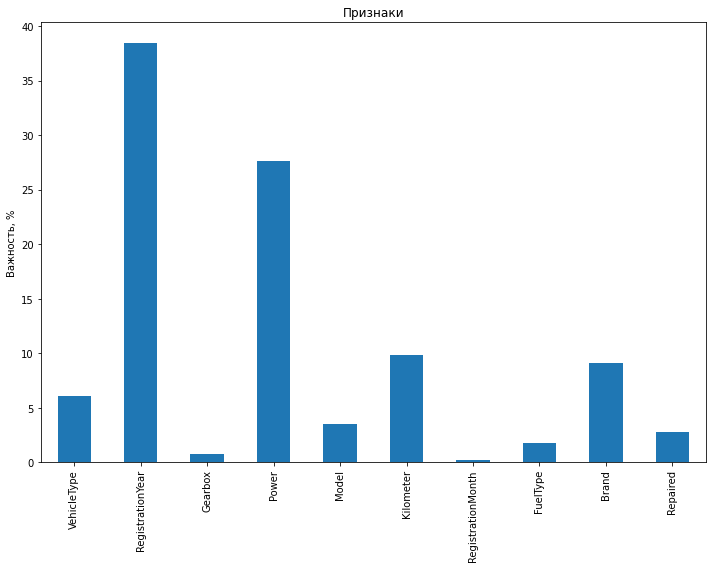

In [51]:
feature_importances = pd.Series(model.get_feature_importance(),
                         features_tr_vl.columns)
fig, ax = plt.subplots(figsize=(10,8))
feature_importances.plot.bar(ax=ax)
ax.set_title("Признаки")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Как мы видим нам удалось достичь требуемого значения RMSE для модели 'CatBoost' на тестовой выборке. Время обучения и время предсказания у нас также весьма малы (суммарно менее 11 сек). А также мы можем посмотреть на график и понять важности наших факторов 

<b>Вывод: </b> нами был обработан исходный датасет, заполнены пропуски и проанализированы признаки, подготовлено и протестировано несколько моделей. Проанализировав критерии заказчика (качество моделей, время обучения и время предсказания), а также учтя стабильность моделей, мы пришли к выводу, что наиболее подходящей моделью будет "CatBoost" - проверка на тестовой выборке это подтвердила